--- Apresentando o dataset original ---
       0       1       2       3       4       5       6       7       8   \
0  0.0200  0.0371  0.0428  0.0207  0.0954  0.0986  0.1539  0.1601  0.3109   
1  0.0453  0.0523  0.0843  0.0689  0.1183  0.2583  0.2156  0.3481  0.3337   
2  0.0262  0.0582  0.1099  0.1083  0.0974  0.2280  0.2431  0.3771  0.5598   
3  0.0100  0.0171  0.0623  0.0205  0.0205  0.0368  0.1098  0.1276  0.0598   
4  0.0762  0.0666  0.0481  0.0394  0.0590  0.0649  0.1209  0.2467  0.3564   

       9   ...      51      52      53      54      55      56      57  \
0  0.2111  ...  0.0027  0.0065  0.0159  0.0072  0.0167  0.0180  0.0084   
1  0.2872  ...  0.0084  0.0089  0.0048  0.0094  0.0191  0.0140  0.0049   
2  0.6194  ...  0.0232  0.0166  0.0095  0.0180  0.0244  0.0316  0.0164   
3  0.1264  ...  0.0121  0.0036  0.0150  0.0085  0.0073  0.0050  0.0044   
4  0.4459  ...  0.0031  0.0054  0.0105  0.0110  0.0015  0.0072  0.0048   

       58      59  60  
0  0.0090  0.0032   R  
1  0

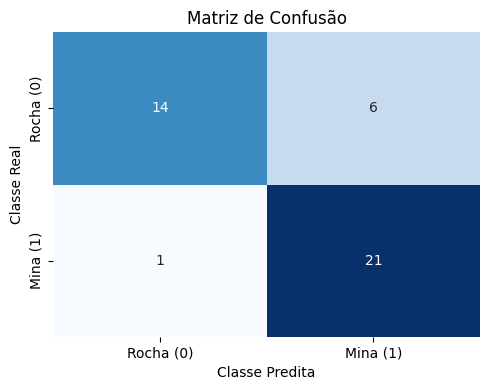


Curva ROC salva como 'roc_curve.png'.


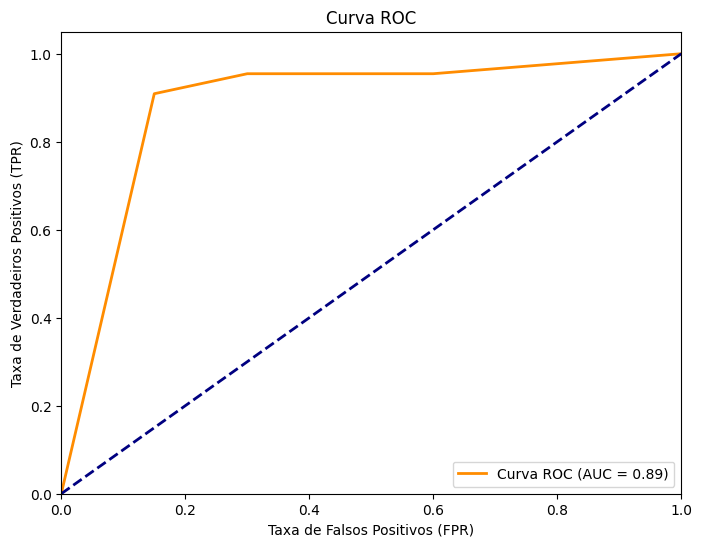


Visualização PCA 2D salva como 'pca_2d.png'.


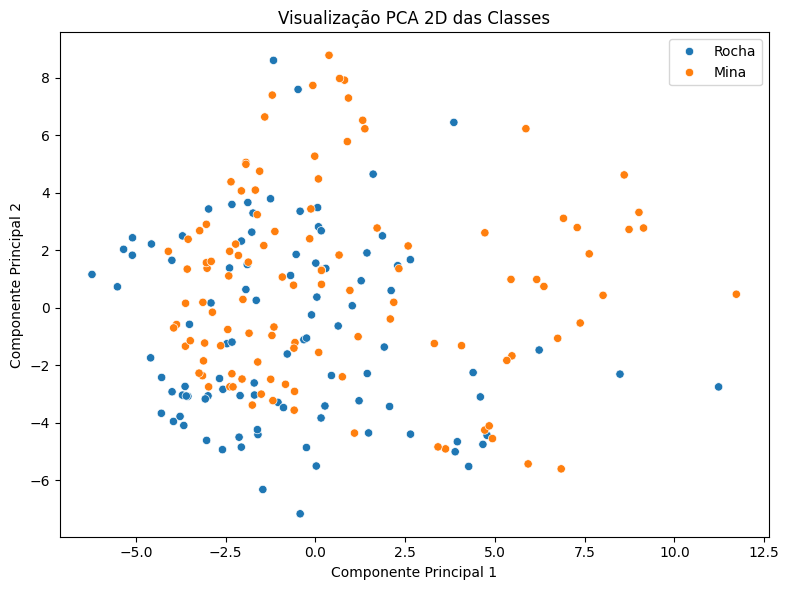

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc
)

# URL do dataset
URL = "https://raw.githubusercontent.com/professortiagoinfnet/inteligencia_artificial/refs/heads/main/sonar_dataset.csv"
SEED = 42  # Semente para reprodutibilidade


def carregar_dataset(url):
    """
    Carrega o dataset a partir de uma URL CSV.

    Parâmetros:
    url (str): URL do arquivo CSV.

    Retorna:
    DataFrame do pandas com os dados carregados.
    """
    try:
        return pd.read_csv(url, header=None)
    except Exception as e:
        raise RuntimeError(f"Erro ao carregar o dataset: {e}")


def separar_features(df):
    """
    Separa as features (X) e o target (y) do DataFrame.

    Parâmetros:
    df (DataFrame): DataFrame com os dados.

    Retorna:
    X (DataFrame): Features.
    y (Series): Target.
    """
    try:
        return df.iloc[:, :-1], df.iloc[:, -1]
    except Exception as e:
        raise RuntimeError(f"Erro ao separar features e target: {e}")


def codificar_target(y):
    """
    Codifica a variável target (R -> 0, M -> 1).

    Parâmetros:
    y (Series): Target original.

    Retorna:
    y (Series): Target codificado.
    """
    try:
        return y.map({'R': 0, 'M': 1})
    except Exception as e:
        raise RuntimeError(f"Erro ao codificar o target: {e}")


def dividir_dados(X, y, seed):
    """
    Divide os dados em treino e teste com estratificação.

    Parâmetros:
    X (DataFrame): Features.
    y (Series): Target.
    seed (int): Semente para reprodutibilidade.

    Retorna:
    X_train, X_test, y_train, y_test
    """
    return train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)


def padronizar_features(X_train, X_test):
    """
    Padroniza os dados com StandardScaler.

    Parâmetros:
    X_train (ndarray): Conjunto de treino.
    X_test (ndarray): Conjunto de teste.

    Retorna:
    X_train_scaled, X_test_scaled (arrays): Dados padronizados.
    """
    scaler = StandardScaler()
    return scaler.fit_transform(X_train), scaler.transform(X_test)


def aplicar_pca(X_train, X_test, n_components, seed):
    """
    Aplica PCA para redução de dimensionalidade.

    Parâmetros:
    X_train, X_test (arrays): Dados padronizados.
    n_components (float ou int): Número de componentes ou variância desejada.
    seed (int): Semente para reprodutibilidade.

    Retorna:
    X_train_pca, X_test_pca (arrays): Dados transformados pelo PCA.
    """
    pca = PCA(n_components=n_components, random_state=seed)
    return pca.fit_transform(X_train), pca.transform(X_test)


def buscar_melhores_hiperparametros(X_train, y_train, seed):
    """
    Realiza busca de hiperparâmetros com GridSearchCV.

    Parâmetros:
    X_train (array): Dados de treino após PCA.
    y_train (array): Target de treino.
    seed (int): Semente para reprodutibilidade.

    Retorna:
    best_model: Melhor estimador encontrado.
    best_params: Dicionário com os melhores hiperparâmetros.
    best_score: Melhor acurácia média na validação cruzada.
    """
    dtree = DecisionTreeClassifier(random_state=seed)

    # Grade de hiperparâmetros para otimização
    param_grid = {
        'max_depth': [None, 5, 10, 15, 20],
        'min_samples_leaf': [1, 5, 10, 20],
        'criterion': ['gini', 'entropy'],
        'ccp_alpha': [0.0, 0.001, 0.005, 0.01, 0.02, 0.05, 0.1]
    }

    grid_search = GridSearchCV(
        estimator=dtree,
        param_grid=param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )

    # Treina com validação cruzada
    grid_search.fit(X_train, y_train)

    return grid_search.best_estimator_, grid_search.best_params_, grid_search.best_score_


def avaliar_modelo(modelo, X_test, y_test):
    """
    Avalia o modelo com métricas e matriz de confusão.

    Parâmetros:
    modelo: Modelo treinado.
    X_test (array): Dados de teste.
    y_test (array): Rótulos reais.

    Retorna:
    y_test, y_prob: Rótulos reais e probabilidades preditas da classe positiva.
    """
    y_pred = modelo.predict(X_test)
    y_prob = modelo.predict_proba(X_test)[:, 1]  # Probabilidades da classe 1 (mina)

    # Cálculo de métricas
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Matriz de confusão
    conf_matrix = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    # Exibição das métricas
    print("\n--- Avaliação do Classificador ---")
    print(f"Acurácia: {acc:.4f}")
    print(f"Precisão: {prec:.4f}")
    print(f"Recall (Sensibilidade): {rec:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Especificidade: {specificity:.4f}")

    print("\n--- Relatório de Classificação ---")
    print(classification_report(y_test, y_pred))

    return y_test, y_prob


def plotar_matriz_confusao(y_test, y_pred, salvar_em=None):
    """
    Plota a matriz de confusão de forma visual com seaborn.

    Parâmetros:
    y_test (array): Rótulos reais.
    y_pred (array): Rótulos preditos pelo modelo.
    salvar_em (str): Caminho do arquivo para salvar o gráfico (opcional).
    """
    from sklearn.metrics import confusion_matrix
    import seaborn as sns

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Rocha (0)", "Mina (1)"],
                yticklabels=["Rocha (0)", "Mina (1)"])
    plt.title("Matriz de Confusão")
    plt.xlabel("Classe Predita")
    plt.ylabel("Classe Real")
    plt.tight_layout()

    if salvar_em:
        plt.savefig(salvar_em)
        print(f"\nMatriz de confusão salva como '{salvar_em}'.")

    plt.show()


def plotar_curva_roc(y_test, y_prob, salvar_em=None):
    """
    Plota e salva a Curva ROC.

    Parâmetros:
    y_test (array): Rótulos reais.
    y_prob (array): Probabilidades da classe positiva.
    salvar_em (str): Caminho do arquivo para salvar o gráfico (opcional).
    """
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"Curva ROC (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("Taxa de Falsos Positivos (FPR)")
    plt.ylabel("Taxa de Verdadeiros Positivos (TPR)")
    plt.title("Curva ROC")
    plt.legend(loc='lower right')

    if salvar_em:
        plt.savefig(salvar_em)
        print(f"\nCurva ROC salva como '{salvar_em}'.")

    plt.show()


def visualizar_pca_2d(X, y, salvar_em=None):
    """
    Aplica PCA 2D para visualização e plota as amostras por classe.

    Parâmetros:
    X (DataFrame): Features originais.
    y (Series): Target codificado.
    salvar_em (str): Caminho do arquivo para salvar o gráfico (opcional).
    """
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    pca = PCA(n_components=2)
    X_pca_2d = pca.fit_transform(X_scaled)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_pca_2d[:, 0], y=X_pca_2d[:, 1], hue=y.map({0: "Rocha", 1: "Mina"}),
                    palette=["#1f77b4", "#ff7f0e"])
    plt.title("Visualização PCA 2D das Classes")
    plt.xlabel("Componente Principal 1")
    plt.ylabel("Componente Principal 2")
    plt.legend()
    plt.tight_layout()

    if salvar_em:
        plt.savefig(salvar_em)
        print(f"\nVisualização PCA 2D salva como '{salvar_em}'.")

    plt.show()


# ---------- FUNÇÃO PRINCIPAL ----------

def main():
    # Carregando e visualizando dataset
    df = carregar_dataset(URL)
    print("--- Apresentando o dataset original ---")
    print(df.head())

    # Separação de variáveis independentes e alvo
    X, y = separar_features(df)
    y = codificar_target(y)

    # Divisão em treino/teste com estratificação
    X_train, X_test, y_train, y_test = dividir_dados(X, y, SEED)

    # Padronização dos dados
    X_train_scaled, X_test_scaled = padronizar_features(X_train, X_test)

    # Redução de dimensionalidade com PCA
    X_train_pca, X_test_pca = aplicar_pca(X_train_scaled, X_test_scaled, n_components=0.95, seed=SEED)

    print(f"\nDimensionalidade original: {X_train.shape[1]} features")
    print(f"Dimensionalidade após PCA: {X_train_pca.shape[1]} componentes principais")

    # Busca pelos melhores hiperparâmetros
    print("\nIniciando GridSearch para encontrar os melhores hiperparâmetros...")
    modelo, melhores_parametros, melhor_score = buscar_melhores_hiperparametros(X_train_pca, y_train, SEED)
    print(f"\nMelhores hiperparâmetros encontrados: {melhores_parametros}")
    print(f"Melhor pontuação (acurácia média da validação cruzada): {melhor_score:.4f}")

    # Avaliação do modelo final no conjunto de teste
    y_test, y_prob = avaliar_modelo(modelo, X_test_pca, y_test)

    # Predições para matriz de confusão
    y_pred = modelo.predict(X_test_pca)
    plotar_matriz_confusao(y_test, y_pred, salvar_em="matriz_confusao.png")

    # Plotagem da curva ROC
    plotar_curva_roc(y_test, y_prob, salvar_em="roc_curve.png")

    # Visualização 2D do dataset com PCA
    visualizar_pca_2d(X, y, salvar_em="pca_2d.png")

# Execução do script
if __name__ == "__main__":
    main()
